# This notebook allows for training and testing that is related to the OXIOD dataset. 

## Tests done so far:

Trained on individual domain training list, and tested on the testing list

## Import Dependencies

In [124]:
#import dependencies
! pip install tensorboardX
! pip install numpy-quaternion
! pip install h5py

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [125]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json
import math


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [126]:
import argparse
args = argparse.Namespace()

#Paths to different files
args.type = 'resnet_diff'
args.root_dir = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld'
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.test_list = osp.join(args.root_dir, 'Test.txt')
args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')


args.test_path = None
args.cache_path = None
args.continue_from = None
args.transfer_from = None


# Params to tune for neural network
args.mode = "train"
args.step_size = 10
args.window_size = 200
args.lr = 1e-04
args.batch_size = 256
args.epochs = 80
args.freeze_params = False

# miscallaneous
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False

# Plots and animation
args.show_plot = True
args.saveAnim = True


np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

In [127]:
_input_channel, _output_channel = 6, 2
_fc_config = {'fc_dim': 512, 'in_dim': 4, 'dropout': 0.5, 'trans_planes': 128}

In [128]:
def run_test(network, data_loader, device, eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for bid, (feat, targ, _, _) in enumerate(data_loader):
        pred = network(feat.to(device)).cpu().detach().numpy()
        targets_all.append(targ.detach().numpy())
        preds_all.append(pred)
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

In [129]:
def add_summary(writer, loss, step, mode):
    names = '{0}_loss/loss_x,{0}_loss/loss_y,{0}_loss/loss_z,{0}_loss/loss_sin,{0}_loss/loss_cos'.format(
        mode).split(',')

    for i in range(loss.shape[0]):
        writer.add_scalar(names[i], loss[i], step)
    writer.add_scalar('{}_loss/avg'.format(mode), np.mean(loss), step)

In [130]:
# This is to get dataset with k fold validation
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False

    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        #transforms = RandomHoriRotate(math.pi * 2)
        transforms = None
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True
        
    # Do k fold cross validation
    elif mode == 'kfold':
        random_shift = args.step_size // 2
        shuffle = True
        transforms = None
        
        import random

        val_size = 1

        # Randomly select elements for the first part
        val_list = random.sample(data_list, val_size)

        # Create the second part by excluding the elements in part1
        train_list = [item for item in data_list if item not in val_list]
        
        print('kfold happening!')
        print('val list: ', val_list)
        print('train list: ', train_list)
        
        seq_type = OxfordGlobSpeedSequence
        train_dataset = StridedSequenceDataset(seq_type, root_dir, train_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
        grv_only=grv_only, transform = transforms, random_shift = random_shift)
        
        val_dataset = StridedSequenceDataset(seq_type, root_dir, val_list, args.cache_path, args.step_size, args.window_size, shuffle = False, 
        grv_only=grv_only, transform = None, random_shift = 0)
        
        return train_dataset, val_dataset
        

    seq_type = OxfordGlobSpeedSequence
    dataset = StridedSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
                                     grv_only=grv_only, transform = transforms, random_shift = random_shift)
    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)    

In [190]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32) # Gets an array of frame IDs which correspond to the sequence. This sequence knows the window size and step size
    #dts = 0.01
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])

    pos = np.zeros([preds.shape[0] + 2, 2])
    # initial position using first position value
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    
    # the intermediate positions using the time interval and adding to initial position
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    
    print('length of pos_pred in func (bfore inter: ', pos.shape)
    
    # This does interpolation because we do not have positions for every timestep. [ts[0] +/- 1e-06] corresponds to the end with an additional small value
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    print(f'pos shape final: {pos.shape}')
    return pos

In [172]:
def write_config(args):
    if args.out_dir:
        with open(osp.join(args.out_dir, 'config.json'), 'w') as f:
            json.dump(vars(args), f)

In [173]:
def showAnimation(video_path):
    import ipywidgets as widgets
    from IPython.display import display
    video_widget = widgets.Video.from_file(video_path)
    video_widget.controls = True
    video_widget.autoplay = True
    display(video_widget)

def plotTrajectory(true_x_values, true_y_values, pred_x_values, pred_y_values):    
    plt.figure('{}'.format("Trajectory"), figsize=(16, 9))

    length = len(true_x_values)
    multiplier = 50
    # creating a blank window
    # for the animation
    fig = plt.figure()
    min_x_value = np.min([np.min(true_x_values), np.min(pred_x_values)])
    max_x_value = np.max([np.max(true_x_values), np.max(pred_x_values)])
    min_y_value = np.min([np.min(true_y_values), np.min(pred_y_values)])
    max_y_value = np.max([np.max(true_y_values), np.max(pred_y_values)])
    
    
    axis = plt.axes(xlim =(min_x_value, max_x_value), ylim =(min_y_value, max_y_value))
    
    line1, = axis.plot([], [], 'b', label='Line 1')
    line2, = axis.plot([], [], 'r', label='Line 2')

    def init():
        line1.set_data([], [])
        return line1,
    def init():
        line2.set_data([], [])
        return line2,

    # initializing empty values
    # for x and y co-ordinates
    true_xdata, true_ydata, pred_xdata, pred_ydata = [], [], [], []

    # animation function
    def animate(i):
        true_x = true_x_values[i * multiplier]
        true_y = true_y_values[i * multiplier]
        pred_x = pred_x_values[i * multiplier]
        pred_y = pred_y_values[i * multiplier]
        
        true_xdata.append(true_x)
        true_ydata.append(true_y)
        pred_xdata.append(pred_x)
        pred_ydata.append(pred_y)
        
        line1.set_data(true_xdata, true_ydata)
        line2.set_data(pred_xdata, pred_ydata)

        return line1, line2

    # calling the animation function	
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = int(length/multiplier), interval = 0.01, blit = True)
    return anim

In [174]:
import numpy as np
import matplotlib.pyplot as plt

def simple_moving_average(data, window_size):
    """
    Calculate the simple moving average of a given data array using a specified window size.
    
    Args:
        data: The input data array.
        window_size: The size of the moving window.
    
    Returns:
        The array of simple moving averages.
    """
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size


### Training with diff loss as validation

In [143]:
def train(args, **kwargs):
    # Loading data
    start_t = time.time()
    train_dataset = get_dataset_from_list(args.root_dir, args.train_list, args,  mode='train')
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    end_t = time.time()
    print('Training set loaded. Feature size: {}, target size: {}. Time usage: {:.3f}s'.format(
        train_dataset.feature_dim, train_dataset.target_dim, end_t - start_t))
    
    val_dataset, val_loader = None, None
    if args.val_list is not None:
        with open(args.val_list) as f:
            val_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    
    device = torch.device('cuda:0' if torch.cuda.is_available() and not args.cpu else 'cpu')

    summary_writer = None
    
    if args.out_dir is not None:
        if not osp.isdir(args.out_dir):
            os.makedirs(args.out_dir)
        write_config(args)
            
        if not osp.isdir(osp.join(args.out_dir, 'checkpoints')):
            os.makedirs(osp.join(args.out_dir, 'checkpoints'))
        if not osp.isdir(osp.join(args.out_dir, 'logs')):
            os.makedirs(osp.join(args.out_dir, 'logs'))

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1
    network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                           base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)
    network.to(device)

    
    
    print('Number of train samples: {}'.format(len(train_dataset)))
    print('val datasets: {}'.format(val_data_list))
    if val_dataset:
        print('Number of val samples: {}'.format(len(val_dataset)))
    total_params = network.get_num_params()
    print('Total number of parameters: ', total_params)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), args.lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)

    start_epoch = 0
    
    # Continues from last model that was trained
    if args.continue_from is not None and osp.exists(args.continue_from):
        checkpoints = torch.load(args.continue_from)
        start_epoch = checkpoints.get('epoch', 0)
        network.load_state_dict(checkpoints.get('model_state_dict'))
        optimizer.load_state_dict(checkpoints.get('optimizer_state_dict'))       
    
    step = 0
    best_avg_val_loss = np.inf
    best_avg_diff_loss = np.inf

    print('Start from epoch {}'.format(start_epoch))
    total_epoch = start_epoch
    train_losses_all, val_losses_all, diff_losses_all = [], [], []

    # Get the initial loss, this should be with the randomised weights
    init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

    init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
    train_losses_all.append(np.mean(init_train_loss))
    print('-------------------------')
    print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))
    if summary_writer is not None:
        add_summary(summary_writer, init_train_loss, 0, 'train')

    try:
        for epoch in range(start_epoch, args.epochs):           
            
            start_t = time.time()
            network.train()
            train_outs, train_targets = [], []
            for batch_id, (feat, targ, _, _) in enumerate(train_loader):
                feat, targ = feat.to(device), targ.to(device)
                optimizer.zero_grad()
                pred = network(feat)
                train_outs.append(pred.cpu().detach().numpy())
                train_targets.append(targ.cpu().detach().numpy())
                loss = criterion(pred, targ) 
                diff = pred-targ
                mean_diff = torch.mean(torch.abs(torch.mean(diff, axis = 0)))
                
                loss = torch.mean(loss)
                loss.backward()
                optimizer.step()
                step += 1
            train_outs = np.concatenate(train_outs, axis=0)
            train_targets = np.concatenate(train_targets, axis=0)
            train_losses = np.average((train_outs - train_targets) ** 2, axis=0)
            mean_diff_losses = np.abs(np.average(train_outs - train_targets, axis = 0))

            end_t = time.time()
            print('-------------------------')
            print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}, mean diff losses: {}/{:.6f}, final loss: {}'.format(
                epoch, end_t - start_t, train_losses, np.average(train_losses), mean_diff_losses, np.average(mean_diff_losses), np.average(train_losses)))
            
            train_losses_all.append(np.average(train_losses))

            if summary_writer is not None:
                add_summary(summary_writer, train_losses, epoch + 1, 'train')
                summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

            #if we have a validation dataset, checkpoint is saved based on the best validation loss
            
            val_loss_list, diff_lost_list = [], []
            for data in val_data_list:
                
                val_dataset = get_dataset(args.root_dir, [data], args, mode='val')
                val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
                network.eval()
                val_outs, val_targets = run_test(network, val_loader, device)
                
                val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
                diff_losses = np.average((val_outs - val_targets), axis=0)
                
                val_loss_list.append(val_losses)
                diff_lost_list.append(diff_losses)

            val_loss = np.average(val_loss_list, axis = 0)
                  
            diff_loss = np.average(np.abs(diff_lost_list), axis = 0)
            avg_val_loss = np.average(val_loss)
            avg_diff_loss = np.average(diff_loss)
        
            val_losses_all.append(avg_val_loss)
            diff_losses_all.append(avg_diff_loss)
            
            print('Validation loss: {}/{:.6f}, Mean Diff Loss: {}/{}'.format(val_loss, avg_val_loss, diff_loss, avg_diff_loss))
            
            scheduler.step(avg_val_loss)
            if summary_writer is not None:
                add_summary(summary_writer, val_losses, epoch + 1, 'val')
            
            
            
            if avg_diff_loss < best_avg_diff_loss and epoch > 50:
                best_avg_diff_loss = avg_diff_loss
                if args.out_dir and osp.isdir(args.out_dir):
                    model_path = args.model_path
                    torch.save({'model_state_dict': network.state_dict(),
                                'epoch': epoch,
                                'optimizer_state_dict': optimizer.state_dict()}, model_path)
                    print('Model saved to ', model_path)

            total_epoch = epoch

    except KeyboardInterrupt:
        print('-' * 60)
        print('Early terminate')

    print('Training complete')
    return train_losses_all, val_losses_all, diff_losses_all

In [192]:
def test_sequence(args, model_paths):
    args.mode = 'test'
    if args.test_path is not None:
        if args.test_path[-1] == '/':
            args.test_path = args.test_path[:-1]
        root_dir = osp.split(args.test_path)[0]
        test_data_list = [osp.split(args.test_path)[1]]
    elif args.test_list is not None:
        root_dir = args.root_dir
        with open(args.test_list) as f:
            test_data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    else:
        raise ValueError('Either test_path or test_list must be specified.')

    if args.out_dir is not None and not osp.isdir(args.out_dir):
        os.makedirs(args.out_dir)

    if not osp.isdir(osp.join(args.out_dir, 'Videos')) or not osp.isdir(osp.join(args.out_dir, 'Graphs')):
        os.makedirs(osp.join(args.out_dir, 'Videos'))
        os.makedirs(osp.join(args.out_dir, 'Graphs'))

   

    # Load the first sequence to update the input and output size
    _ = get_dataset(root_dir, [test_data_list[0]], args)

    global _fc_config
    _fc_config['in_dim'] = args.window_size // 32 + 1
    
    
    networks = []
    for model_path in model_paths:
        if not torch.cuda.is_available() or args.cpu:
            device = torch.device('cpu')
            checkpoint = torch.load(model_path, map_location=lambda storage, location: storage)
        else:
            device = torch.device('cuda:0')
            checkpoint = torch.load(model_path)
        network = ResNet1D(_input_channel, _output_channel, BasicBlock1D, [2, 2, 2, 2],
                               base_plane=64, output_block=FCOutputModule, kernel_size=3, **_fc_config)

        network.load_state_dict(checkpoint['model_state_dict'])
        network.eval().to(device)
        networks.append(network)
        print('Model {} loaded into network list {}.'.format(model_path, device))

    preds_seq, targets_seq, losses_seq, ate_all, rte_all = [], [], [], [], []
    traj_lens = []

    pred_per_min = 100 * 60

    for data in test_data_list:
        seq_dataset = get_dataset(root_dir, [data], args, mode='test') #theres only 1 sequence in the seq_loader
        seq_loader = DataLoader(seq_dataset, batch_size=1024, shuffle=False)
        ind = np.array([i[1] for i in seq_dataset.index_map if i[0] == 0], dtype=np.int32)

        targets, preds = run_test(network, seq_loader, device, True)
        ensemble_preds = np.zeros(preds.shape)
        
        for network in networks:
            targets, preds = run_test(network, seq_loader, device, True)
            ensemble_preds+=preds
            diff_x = np.mean(preds[:,0] - targets[:,0])
            diff_y = np.mean(preds[:,1] - targets[:,1])
            print('diff_x: ', diff_x)
            print('diff_y: ', diff_y)
        
        ensemble_preds/=len(networks)
        losses = np.mean((targets - ensemble_preds) ** 2, axis=0)
        preds_seq.append(ensemble_preds)
        targets_seq.append(targets)
        losses_seq.append(losses)
        
        
        pos_pred = recon_traj_with_preds(seq_dataset, ensemble_preds)[:, :2]
        pos_gt = seq_dataset.gt_pos[0][:, :2]
        
        
        # Calculates length of a trajectory and appends into list
        traj_lens.append(np.sum(np.linalg.norm(pos_gt[1:] - pos_gt[:-1], axis=1)))
        ate, rte = compute_ate_rte(pos_pred, pos_gt, pred_per_min)
        ate_all.append(ate)
        rte_all.append(rte)
        pos_cum_error = np.linalg.norm(pos_pred - pos_gt, axis=1)

        print('Sequence {}, loss {} / {}, ate {:.6f}, rte {:.6f}'.format(data, losses, np.mean(losses), ate, rte))

        targ_names = ['vx', 'vy']
        kp = 2
        
        
        if args.out_dir is not None and osp.isdir(args.out_dir) and args.saveAnim:
            video_path = osp.join(args.out_dir, 'Videos/' + ''.join(data.split('/')) +'_Trajectory.mp4')
            animation = plotTrajectory(pos_gt[:, 0], pos_gt[:, 1], pos_pred[:, 0], pos_pred[:, 1])
            animation.save(video_path, writer = 'ffmpeg', fps = 50, bitrate = 700)
            showAnimation(video_path)

        plt.figure('{}'.format(data), figsize=(16, 9))
        plt.subplot2grid((kp, 2), (0, 0), rowspan=kp - 1)
        plt.plot(pos_pred[:, 0], pos_pred[:, 1])
        plt.plot(pos_gt[:, 0], pos_gt[:, 1])
        plt.title(data)
        plt.axis('equal')
        plt.legend(['Predicted', 'Ground truth'])
        plt.subplot2grid((kp, 2), (kp - 1, 0))
        plt.plot(pos_cum_error)
        plt.legend(['ATE:{:.3f}, RTE:{:.3f}'.format(ate_all[-1], rte_all[-1])])
        for i in range(kp):
            plt.subplot2grid((kp, 2), (i, 1))
            # plt.plot(ind, preds[:, i])
            # plt.plot(ind, targets[:, i])
            # plt.legend(['Predicted', 'Ground truth'])   
            # plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
            diff = ensemble_preds[:,i] - targets[:,i]
            total_diff = np.sum(diff)/len(diff)
            diff = np.pad(diff, (799,0))
            simple_diff = simple_moving_average(diff, 800)
            mean_diff = np.mean(diff)
            plt.plot(ind, simple_diff)
            plt.legend(['mean_diff:{:.3f}, total_diff:{:.3f}'.format(mean_diff, total_diff)])
            plt.title('{}, error: {:.6f}'.format(targ_names[i], losses[i]))
        plt.tight_layout()
        
        if args.out_dir is not None and osp.isdir(args.out_dir):
            np.save(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.npy'),
                    np.concatenate([pos_pred[:, :2], pos_gt[:, :2]], axis=1))
            plt.savefig(osp.join(args.out_dir, 'Graphs/'+''.join(data.split('/')) + '_gsn.png'))
        
        if args.show_plot:
            plt.show()
        plt.close('all')   

    losses_seq = np.stack(losses_seq, axis=0)
    losses_avg = np.mean(losses_seq, axis=1)
    # Export a csv file
    seq_name = root_dir.split('/')[-1]
    model_type = ''
    if 'txLearning_outputs' in args.model_path:
        model_type = 'TX_'
    if args.out_dir is not None and osp.isdir(args.out_dir):
        with open(osp.join(args.out_dir, 'losses.csv'), 'w') as f:
            if losses_seq.shape[1] == 2:
                f.write(f'seq,vx,vy,avg,{model_type}ate,{model_type}rte\n')
            else:
                f.write(f'seq,vx,vy,vz,avg,{model_type}ate,{model_type}rte\n')
            for i in range(losses_seq.shape[0]):
                f.write(seq_name+'{},'.format(test_data_list[i]))
                for j in range(losses_seq.shape[1]):
                    f.write('{:.6f},'.format(losses_seq[i][j]))
                f.write('{:.6f},{:6f},{:.6f}\n'.format(losses_avg[i], ate_all[i], rte_all[i]))

    print('----------\nOverall loss: {}/{}, avg ATE:{}, avg RTE:{}'.format(
        np.average(losses_seq, axis=0), np.average(losses_avg), np.mean(ate_all), np.mean(rte_all)))
    return losses_avg

# Training Model

Training set loaded. Feature size: 6, target size: 2. Time usage: 0.745s
Number of train samples: 171897
val datasets: ['data2/combined3.csv', 'data2/combined1.csv', 'data1/combined4.csv']
Total number of parameters:  4634882
Start from epoch 0
-------------------------
Init: average loss: [0.198019 0.399650]/0.298835
-------------------------
Epoch 0, time usage: 9.718s, average loss: [0.022718 0.029232]/0.025975, mean diff losses: [0.000982 0.000625]/0.000804, final loss: 0.02597467228770256
Validation loss: [0.017183 0.010474]/0.013829, Mean Diff Loss: [0.007731 0.022262]/0.014996255747973919
-------------------------
Epoch 1, time usage: 9.605s, average loss: [0.006538 0.008346]/0.007442, mean diff losses: [0.000109 0.000090]/0.000100, final loss: 0.0074420771561563015
Validation loss: [0.017945 0.010981]/0.014463, Mean Diff Loss: [0.012735 0.011198]/0.011966269463300705
-------------------------
Epoch 2, time usage: 9.342s, average loss: [0.005486 0.007266]/0.006376, mean diff los


KeyboardInterrupt



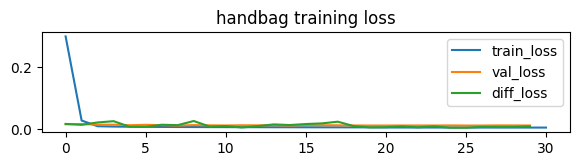

In [194]:
i = 1
fig = plt.figure(figsize=(15, 6))
fig.tight_layout()
args.epochs = 150
#num_models = 1
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']

for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.train_list = osp.join(args.root_dir, 'Train.txt')
    args.val_list = osp.join(args.root_dir, 'Validation.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_diff_loss.pt')
    args.continue_from = None
    #train_losses, val_losses = train(args)
    train_losses, val_losses, diff_losses = train(args)
    plt.subplot(math.ceil(len(data_path_list) / 2), 2 , i)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.plot(diff_losses)
    plt.title(data+' training loss')
    plt.legend(['train_loss', 'val_loss', 'diff_loss'])
    i += 1


=============================================================================outputs for handbag ==============================================================
Model /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/resnet_diff_outputs/checkpoints/checkpoint_diff_loss.pt loaded into network list cuda:0.
diff_x:  -0.0038647128
diff_y:  0.00016417555
length of pos_pred in func (bfore inter:  (57301, 2)
pos shape final: (57499, 2)
Sequence data1/combined1.csv, loss [0.000603 0.000652] / 0.0006277358373046641, ate 1.080925, rte 0.668654


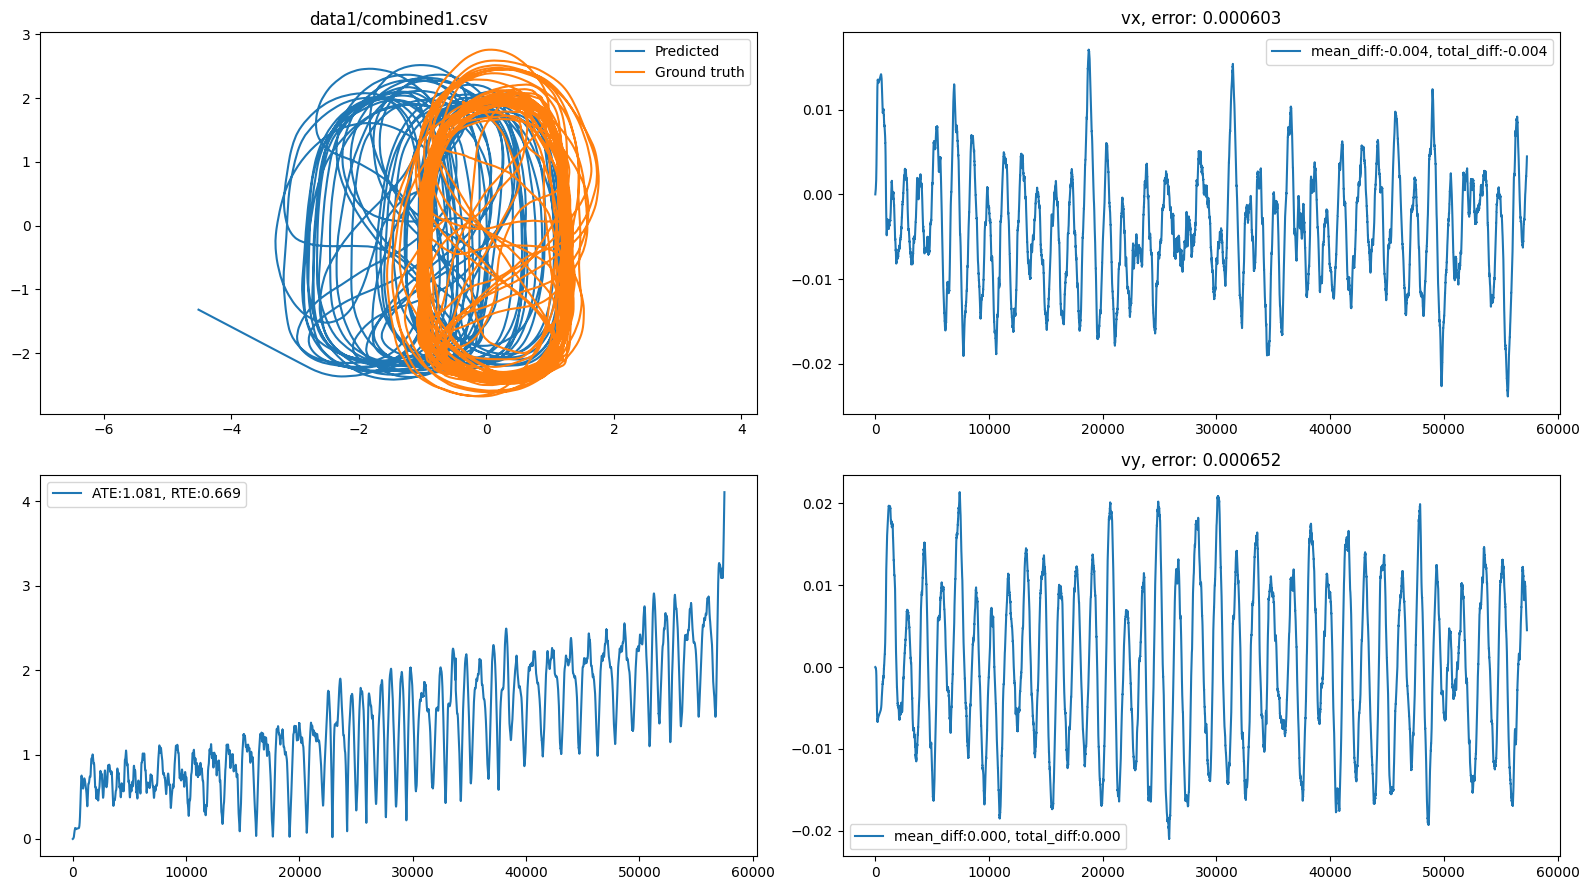

diff_x:  -0.0045795687
diff_y:  -0.00016289906
length of pos_pred in func (bfore inter:  (56801, 2)
pos shape final: (56999, 2)
Sequence data1/combined2.csv, loss [0.000611 0.000708] / 0.0006598716740513302, ate 1.194237, rte 0.921007


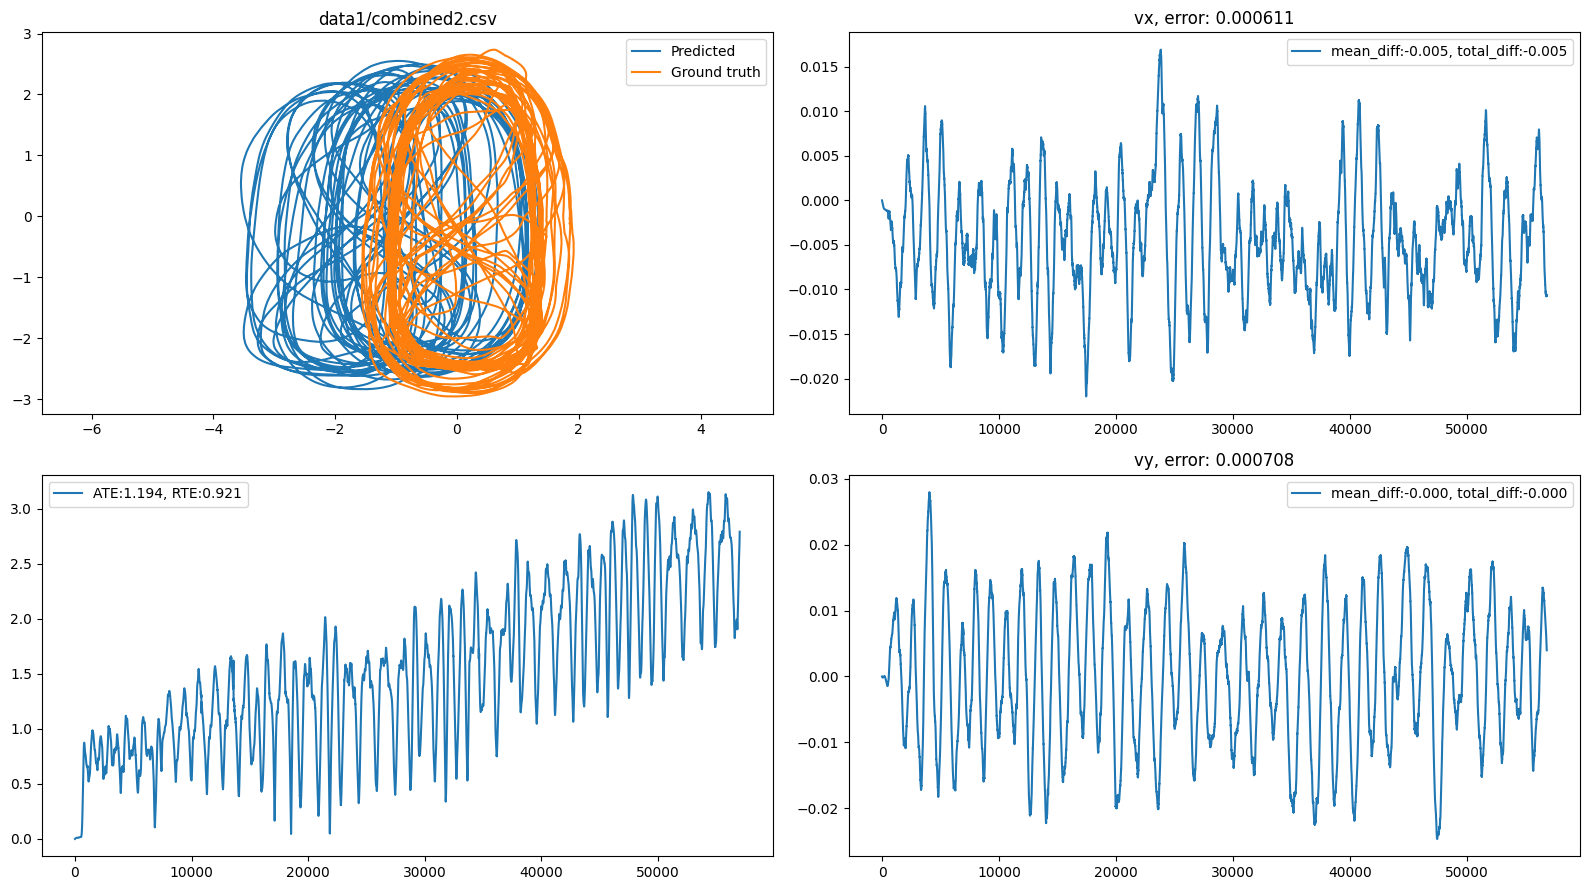

diff_x:  -0.0031919088
diff_y:  0.00049405004
length of pos_pred in func (bfore inter:  (57801, 2)
pos shape final: (57999, 2)
Sequence data1/combined3.csv, loss [0.000682 0.000726] / 0.0007044088370488292, ate 0.965022, rte 0.891520


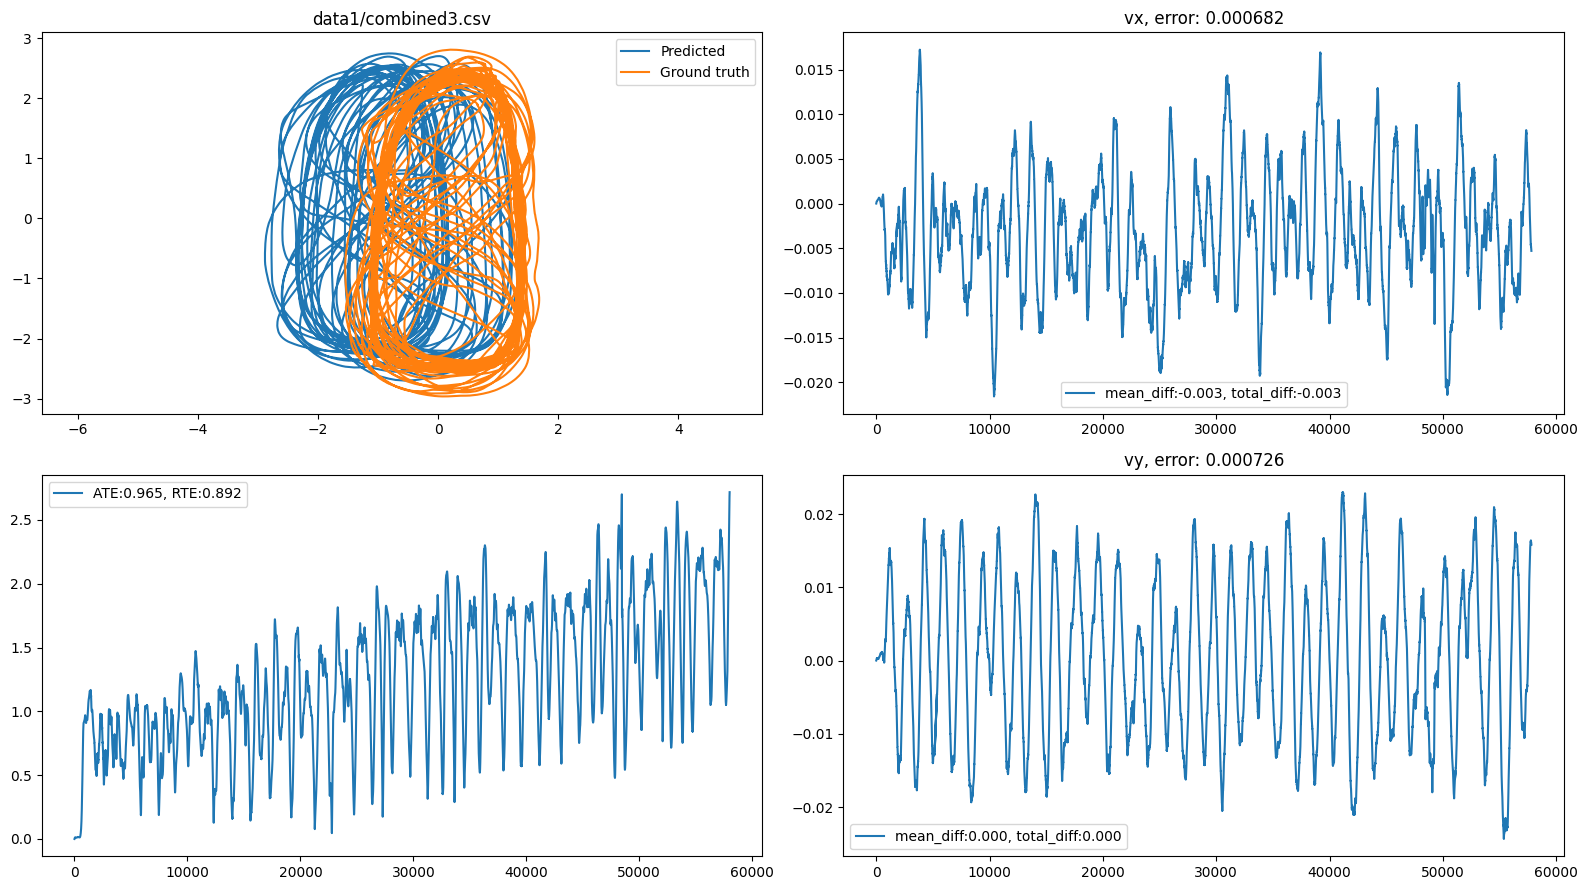

----------
Overall loss: [0.000632 0.000696]/0.0006640054494682744, avg ATE:1.0800611923485366, avg RTE:0.827060235798376
=============================================================================outputs for handheld ==============================================================
Model /home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld/resnet_diff_outputs/checkpoints/checkpoint_diff_loss.pt loaded into network list cuda:0.
diff_x:  -0.00068088324
diff_y:  -0.0011089896
length of pos_pred in func (bfore inter:  (37403, 2)
pos shape final: (37601, 2)
Sequence data1/combined1.csv, loss [0.000433 0.000371] / 0.00040239427009964245, ate 0.586321, rte 0.774667


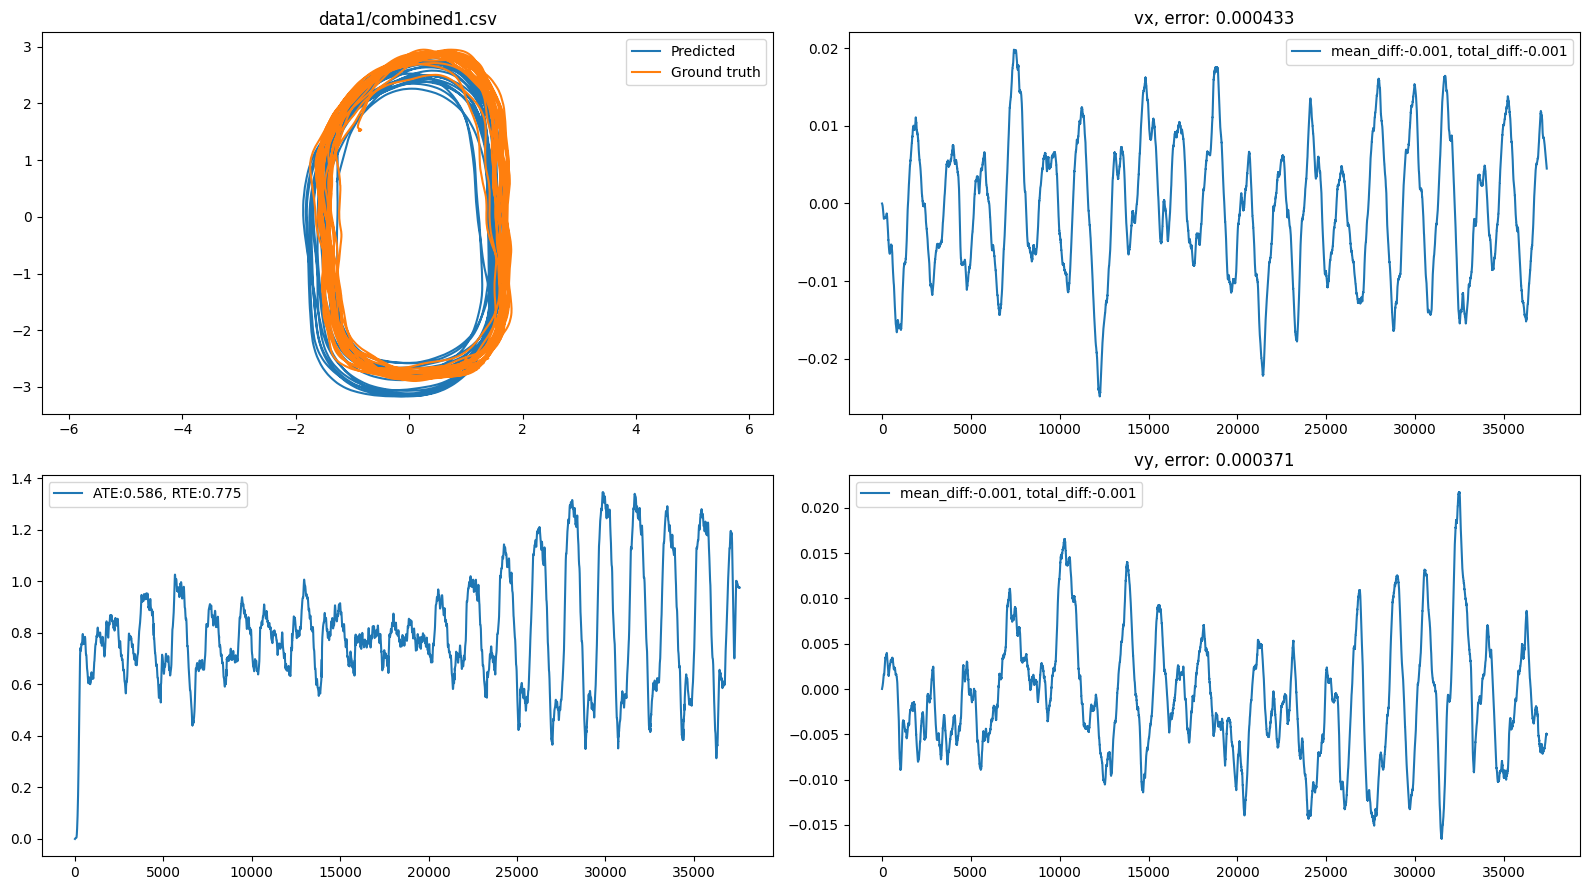

diff_x:  -0.0008632768
diff_y:  -0.003009766
length of pos_pred in func (bfore inter:  (18651, 2)
pos shape final: (18849, 2)
Sequence data1/combined3.csv, loss [0.000507 0.000411] / 0.00045885761799061047, ate 0.572518, rte 0.640194


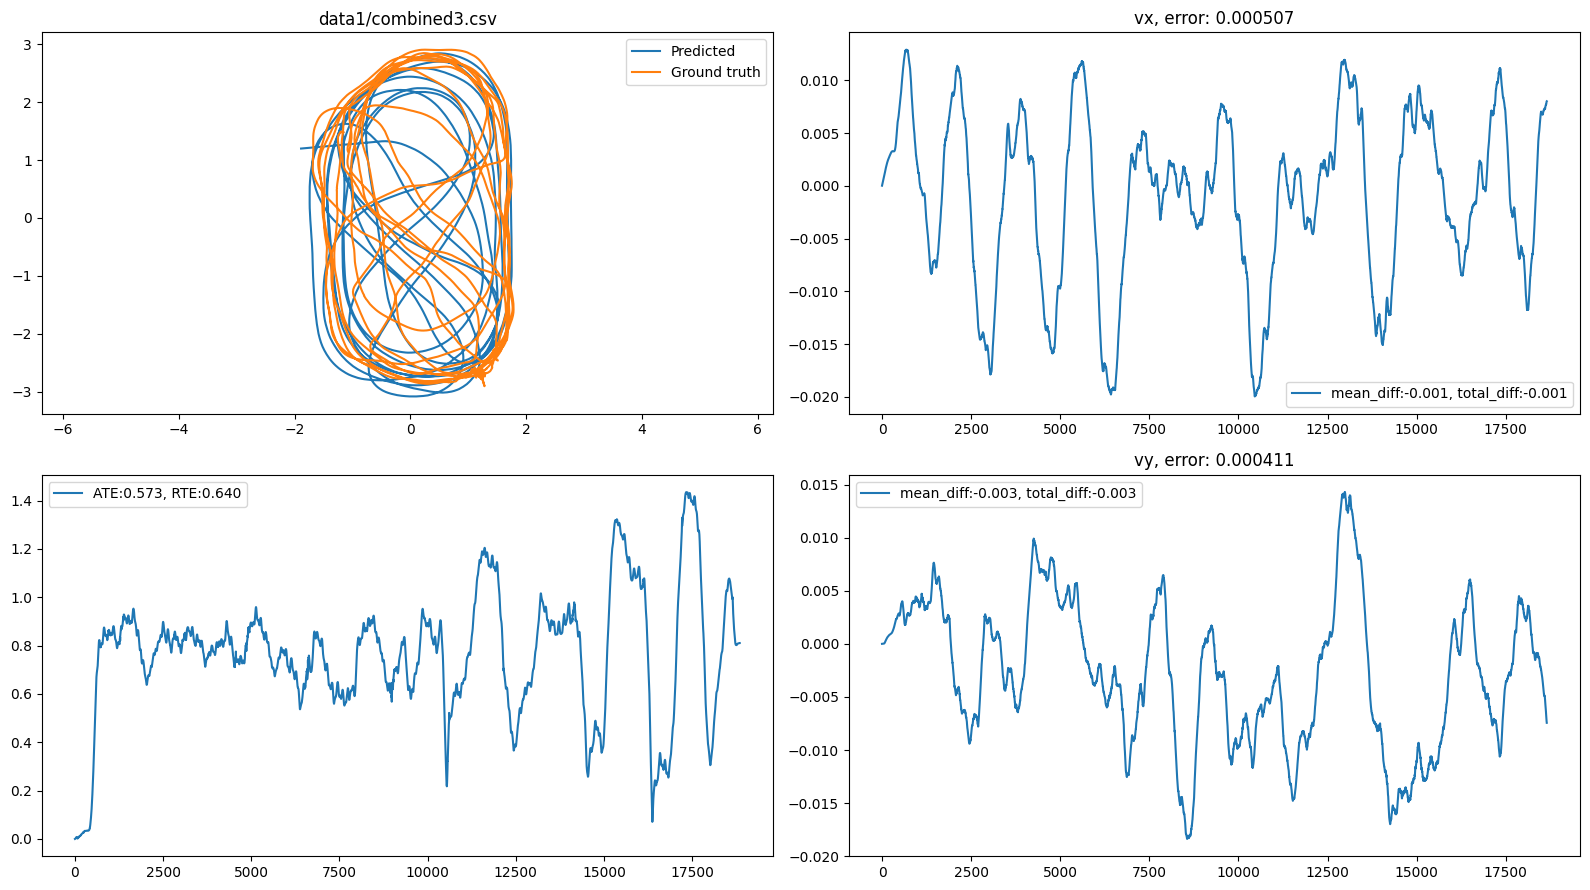

diff_x:  0.00078941387
diff_y:  -0.0022942284
length of pos_pred in func (bfore inter:  (21442, 2)
pos shape final: (21640, 2)
Sequence data1/combined4.csv, loss [0.000438 0.000397] / 0.000417479348582363, ate 0.556073, rte 0.670368


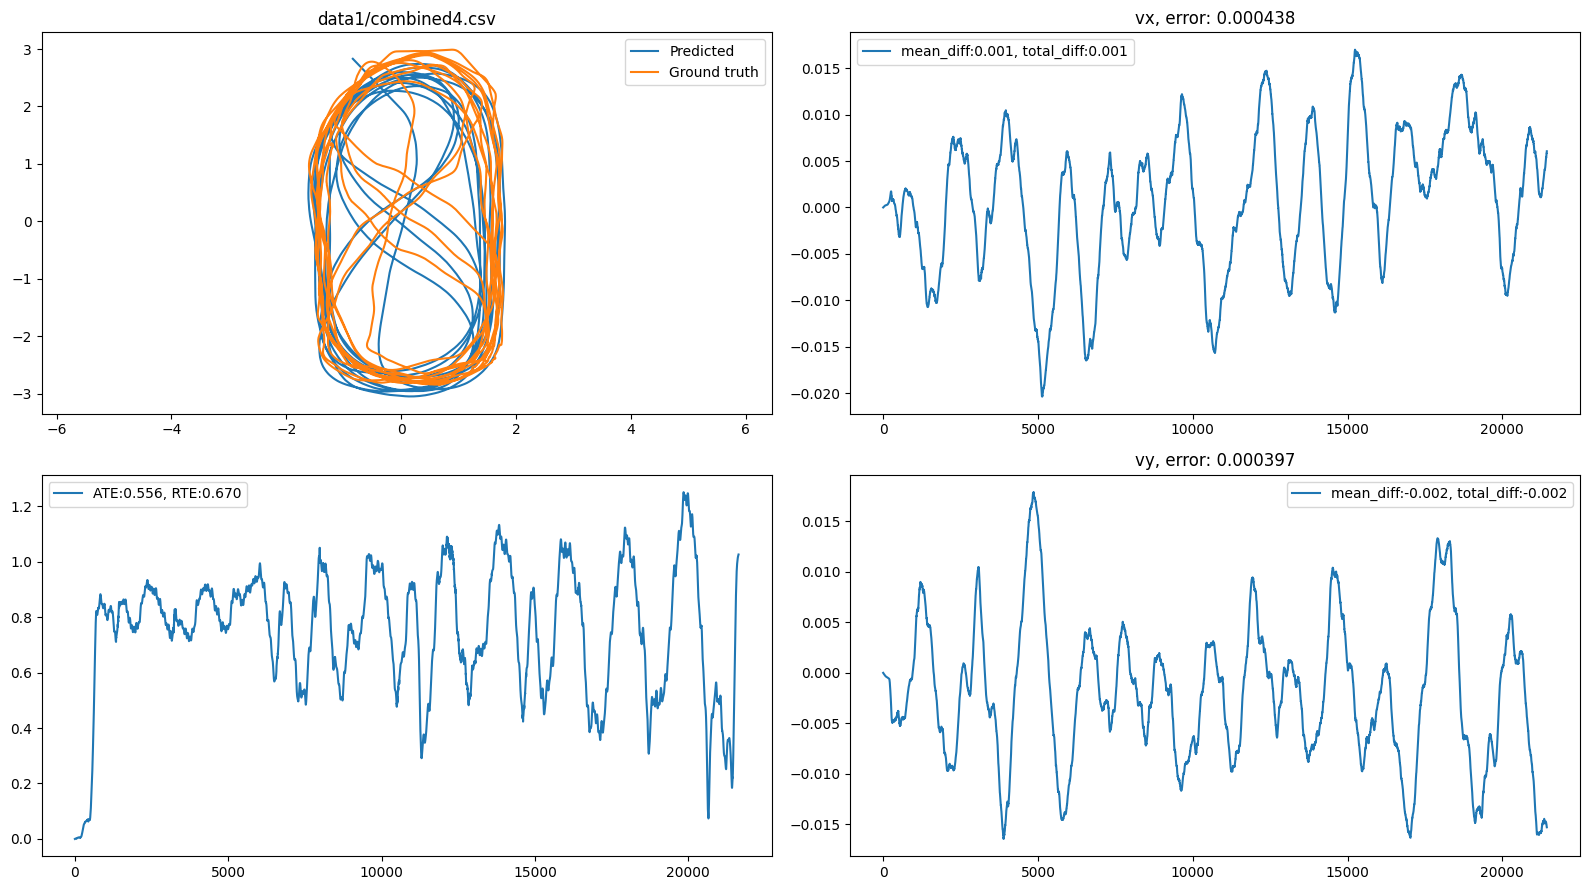

diff_x:  -0.0016608195
diff_y:  -0.0015820734
length of pos_pred in func (bfore inter:  (31961, 2)
pos shape final: (32159, 2)
Sequence data1/combined5.csv, loss [0.000568 0.000456] / 0.0005123265207501509, ate 0.661960, rte 0.956944


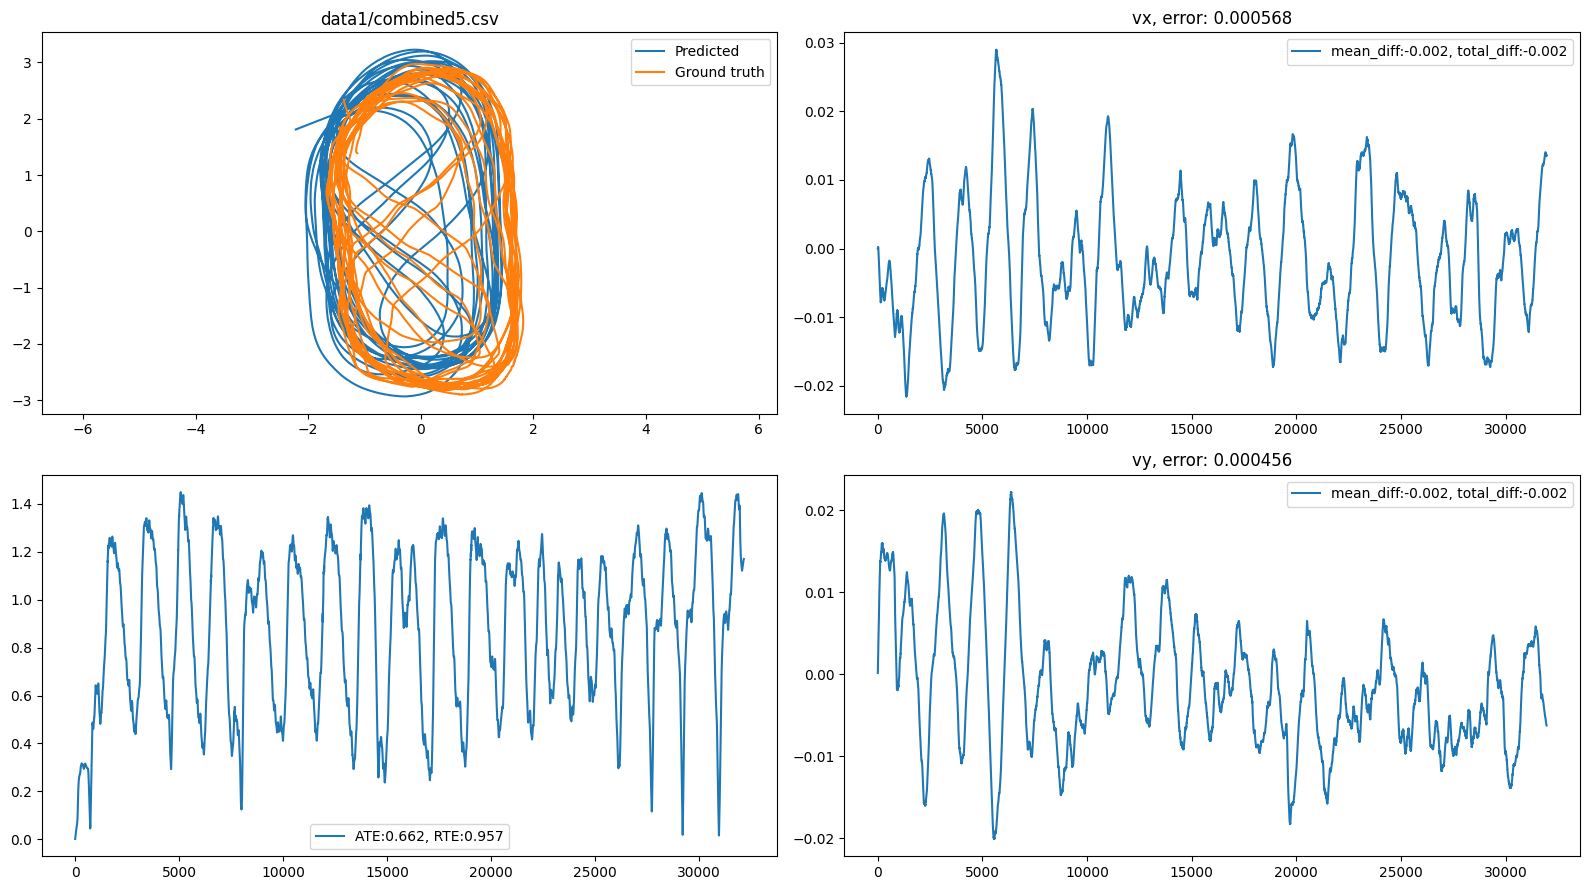

diff_x:  -0.0004883577
diff_y:  -0.002851903
length of pos_pred in func (bfore inter:  (32338, 2)
pos shape final: (32536, 2)
Sequence data1/combined6.csv, loss [0.000574 0.000461] / 0.0005174640390599976, ate 0.667117, rte 0.786658


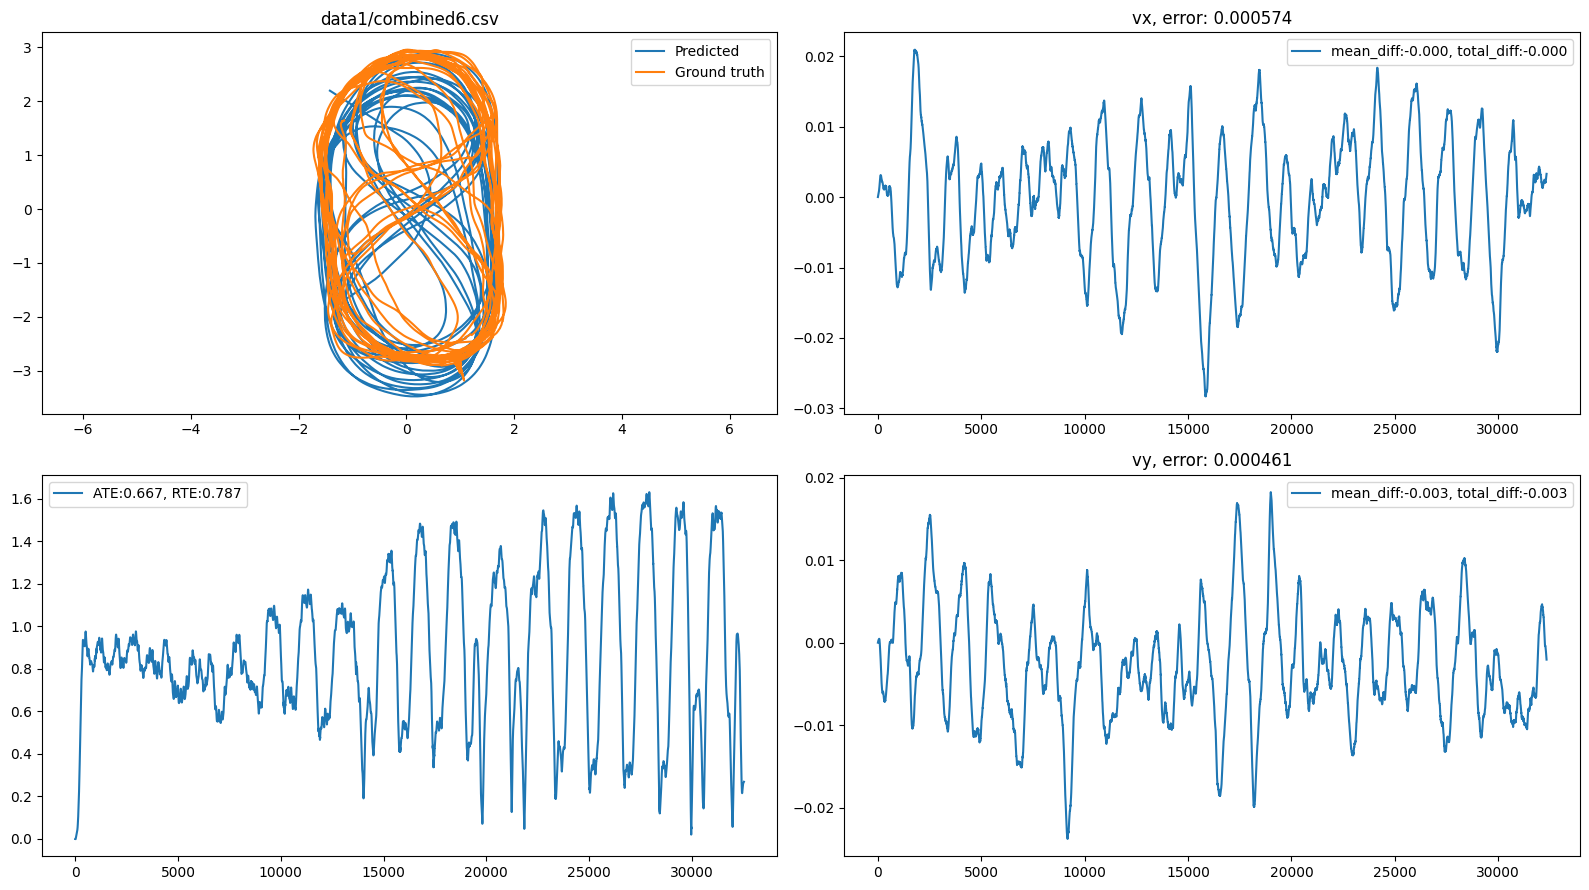

diff_x:  -0.00021185871
diff_y:  -0.0018747771
length of pos_pred in func (bfore inter:  (13899, 2)
pos shape final: (14097, 2)
Sequence data1/combined7.csv, loss [0.000658 0.000529] / 0.0005938188907939086, ate 0.583647, rte 1.001149


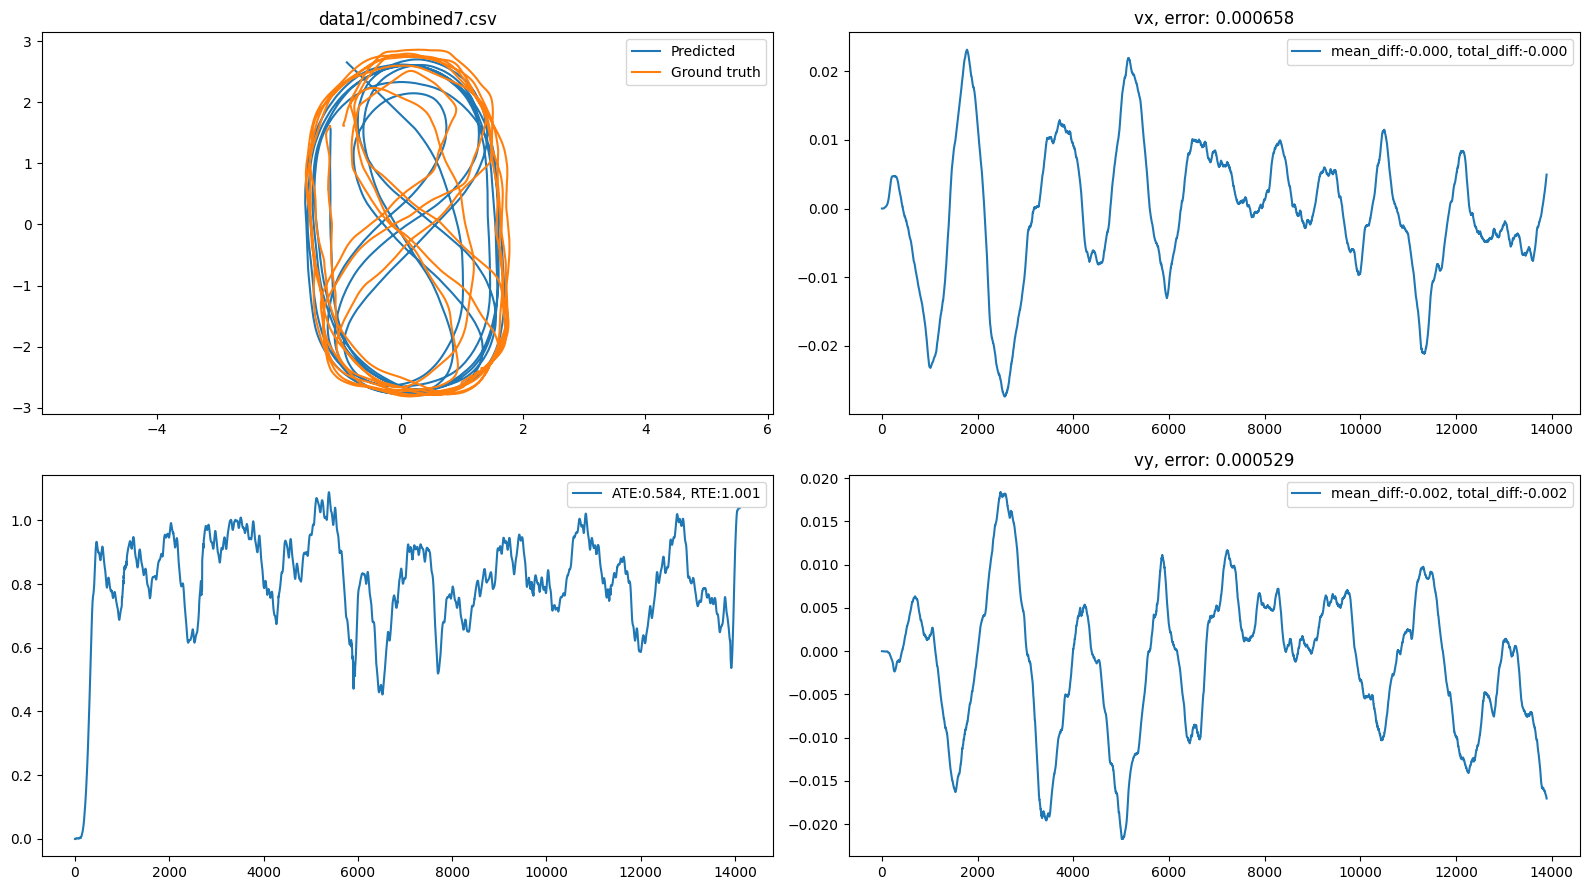

diff_x:  -0.0032189405
diff_y:  -0.0018757385
length of pos_pred in func (bfore inter:  (32419, 2)
pos shape final: (32617, 2)
Sequence data2/combined1.csv, loss [0.000610 0.000443] / 0.0005269384214818503, ate 0.749659, rte 0.897564


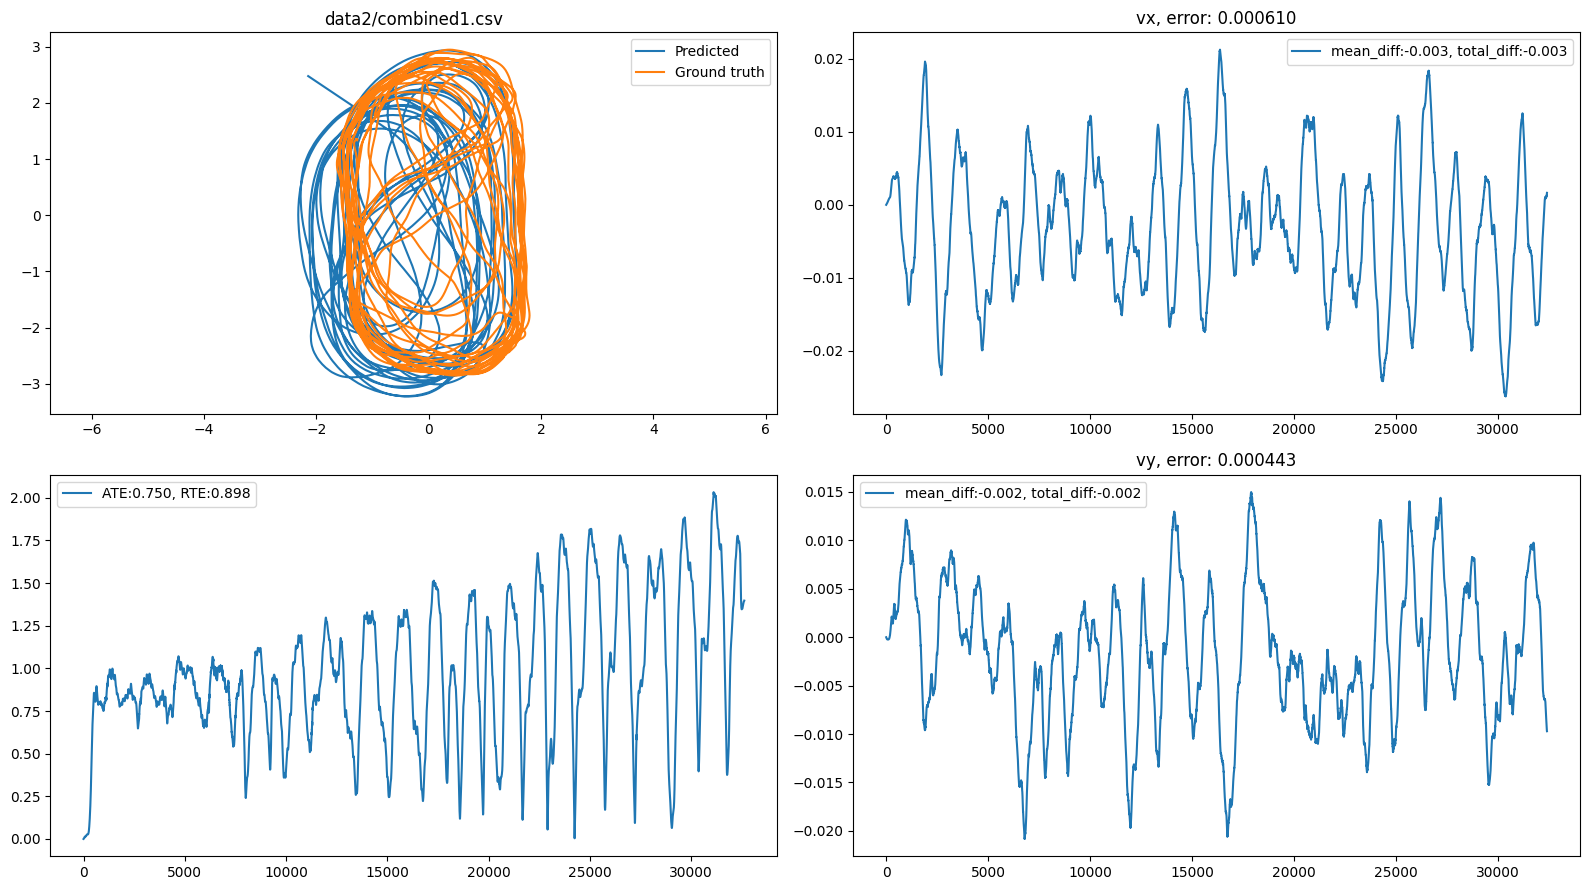

diff_x:  -2.2259235e-05
diff_y:  -0.002134609
length of pos_pred in func (bfore inter:  (30980, 2)
pos shape final: (31178, 2)
Sequence data2/combined2.csv, loss [0.000637 0.000457] / 0.0005468041130406743, ate 0.609621, rte 1.009589


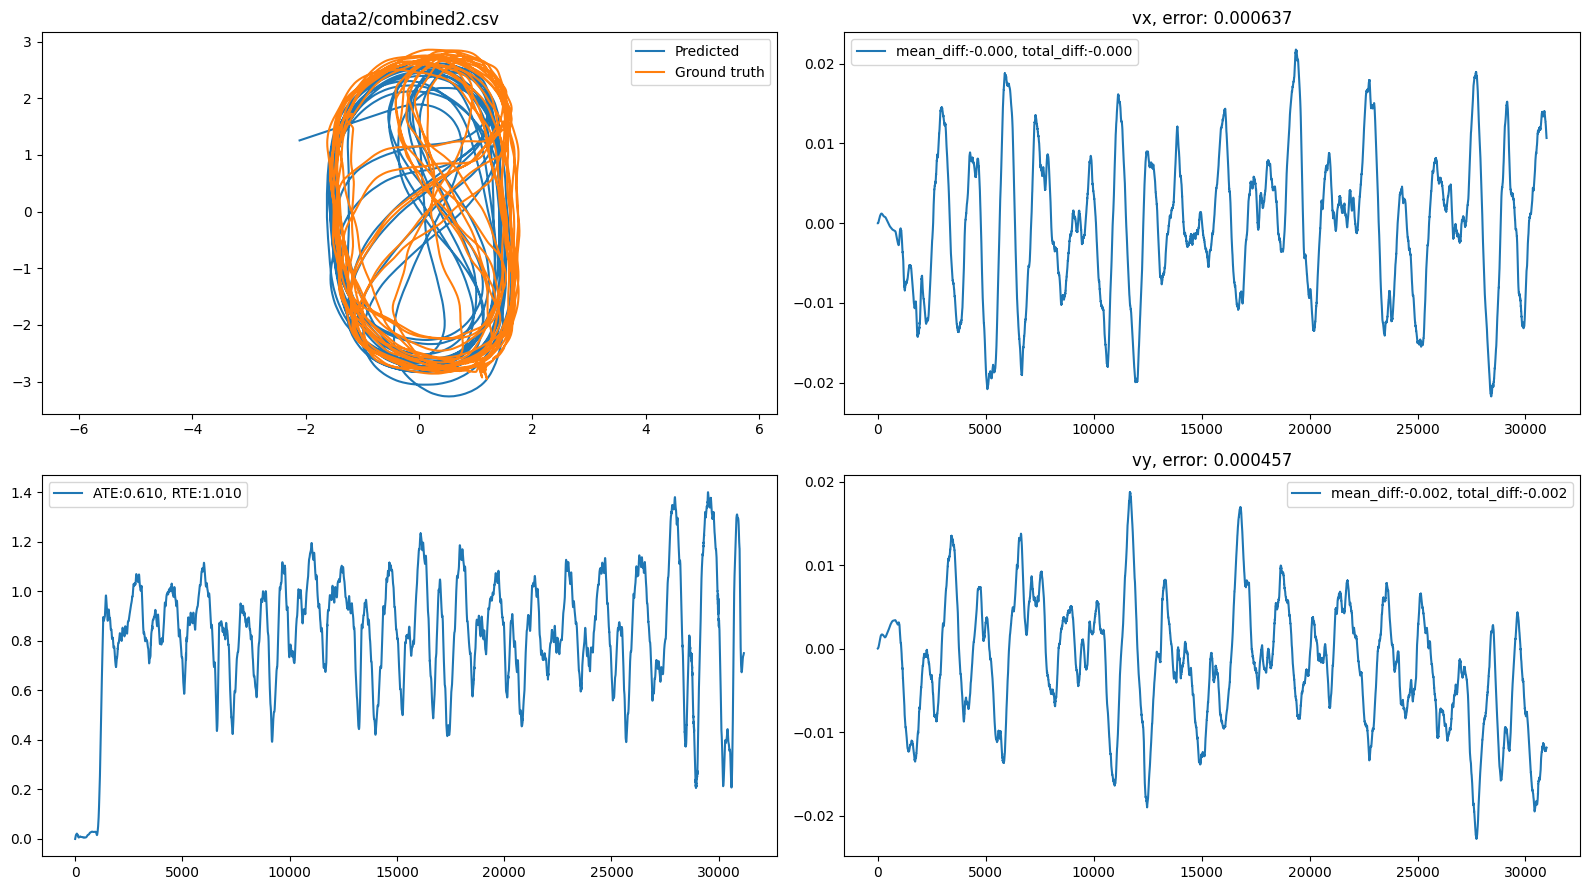

diff_x:  -0.0026081193
diff_y:  -0.003251962
length of pos_pred in func (bfore inter:  (29860, 2)
pos shape final: (30058, 2)
Sequence data2/combined3.csv, loss [0.000630 0.000415] / 0.0005224270544098694, ate 0.727910, rte 0.971488


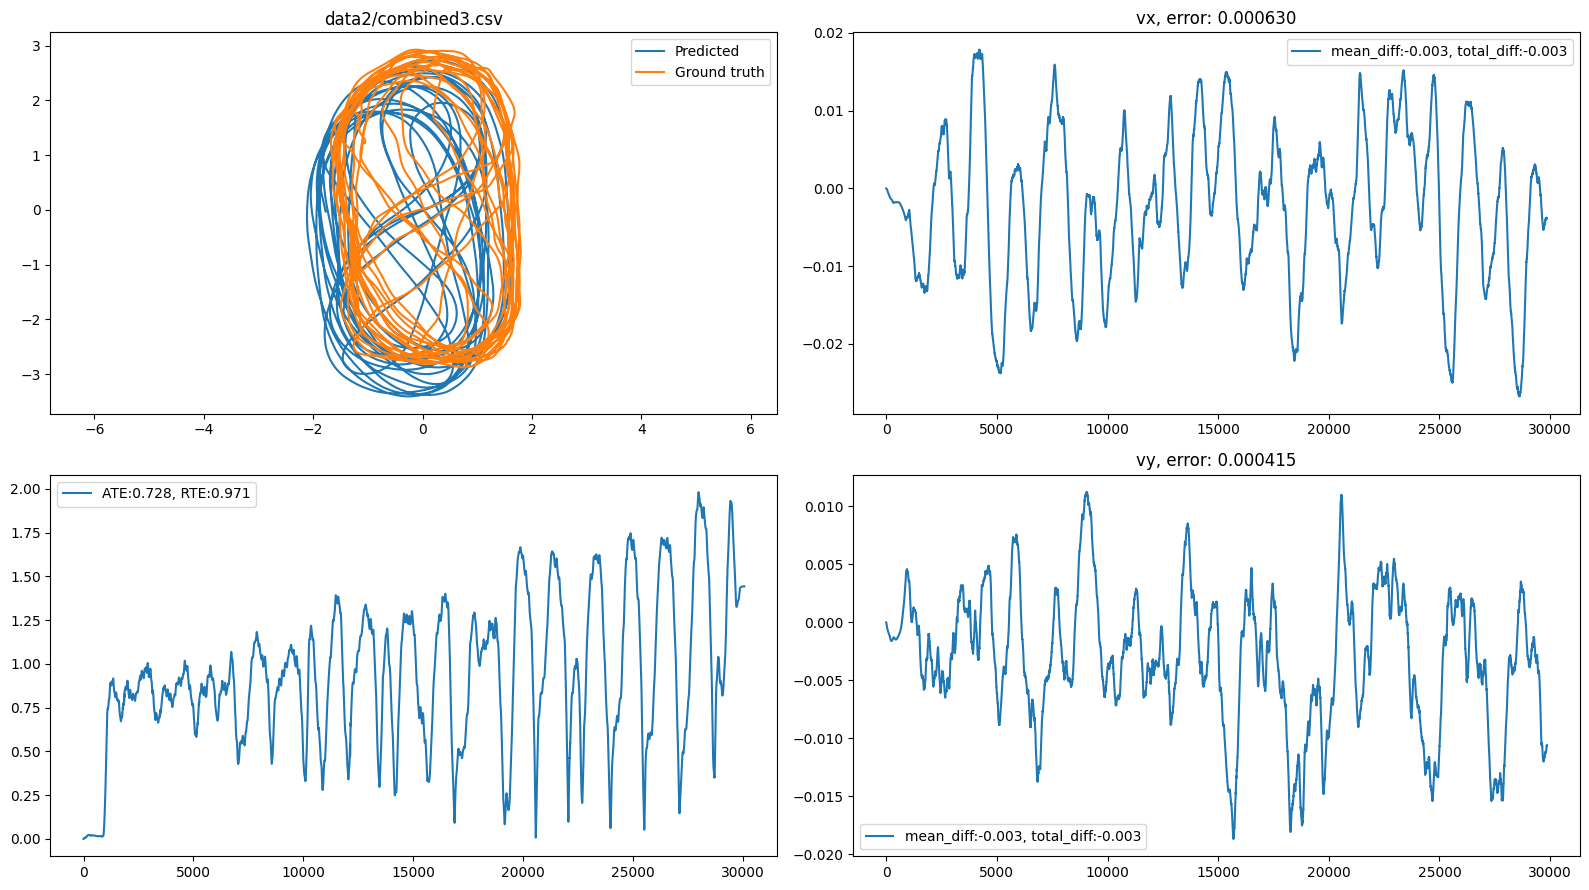

diff_x:  -0.002932702
diff_y:  -0.003248868
length of pos_pred in func (bfore inter:  (30557, 2)
pos shape final: (30755, 2)
Sequence data3/combined1.csv, loss [0.000622 0.000528] / 0.0005750016137916938, ate 0.804377, rte 0.874325


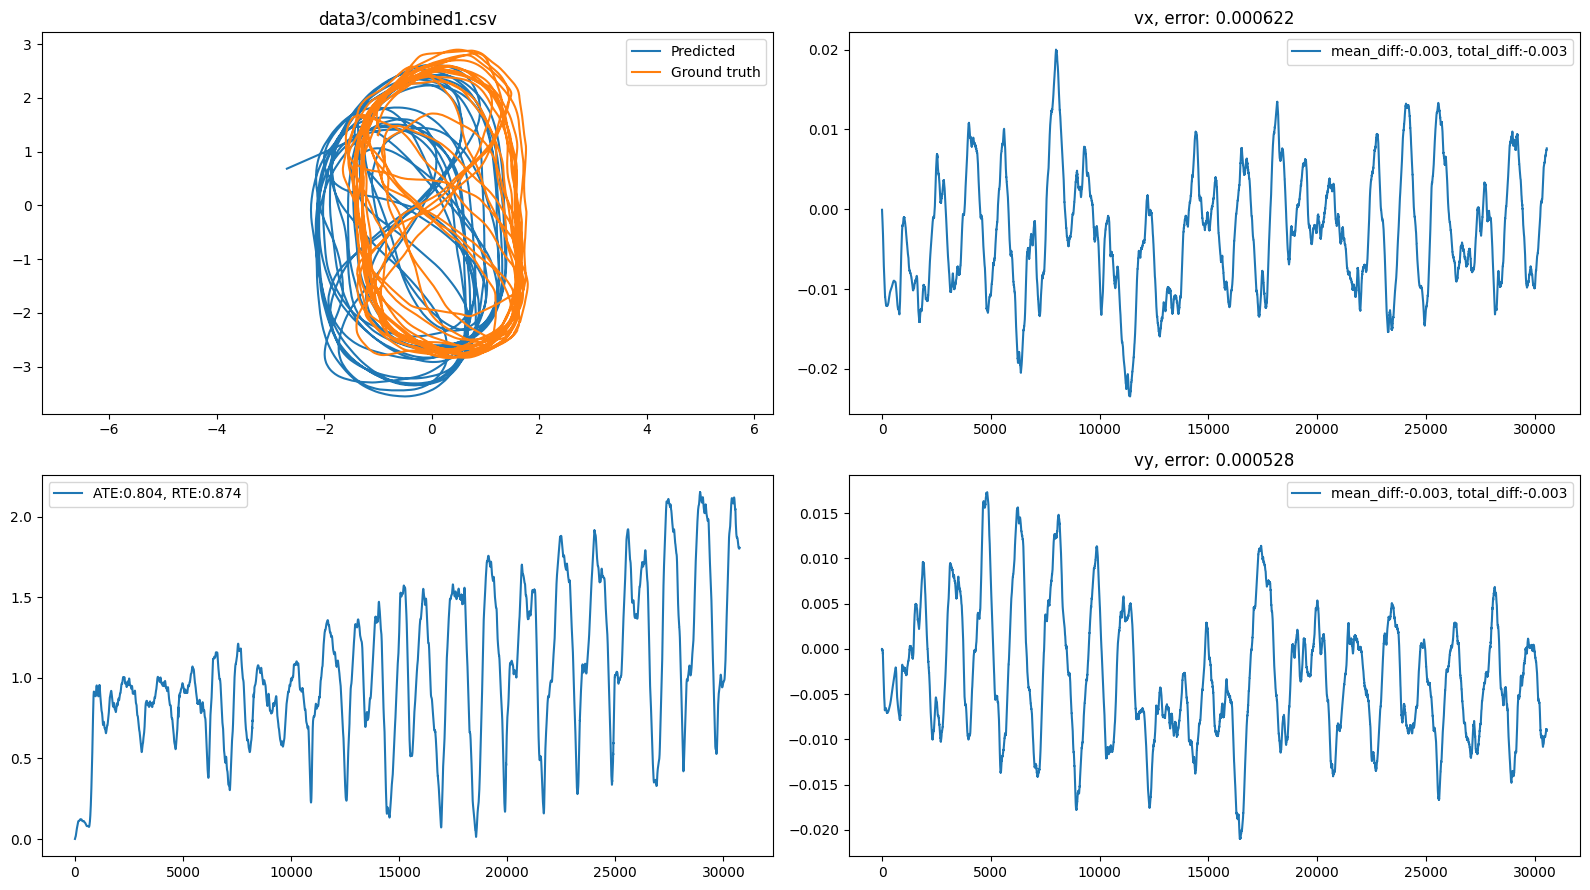

diff_x:  -0.0013319798
diff_y:  -0.0031409936
length of pos_pred in func (bfore inter:  (37711, 2)
pos shape final: (37909, 2)
Sequence data3/combined2.csv, loss [0.000566 0.000526] / 0.0005462328208678748, ate 0.851063, rte 0.881302


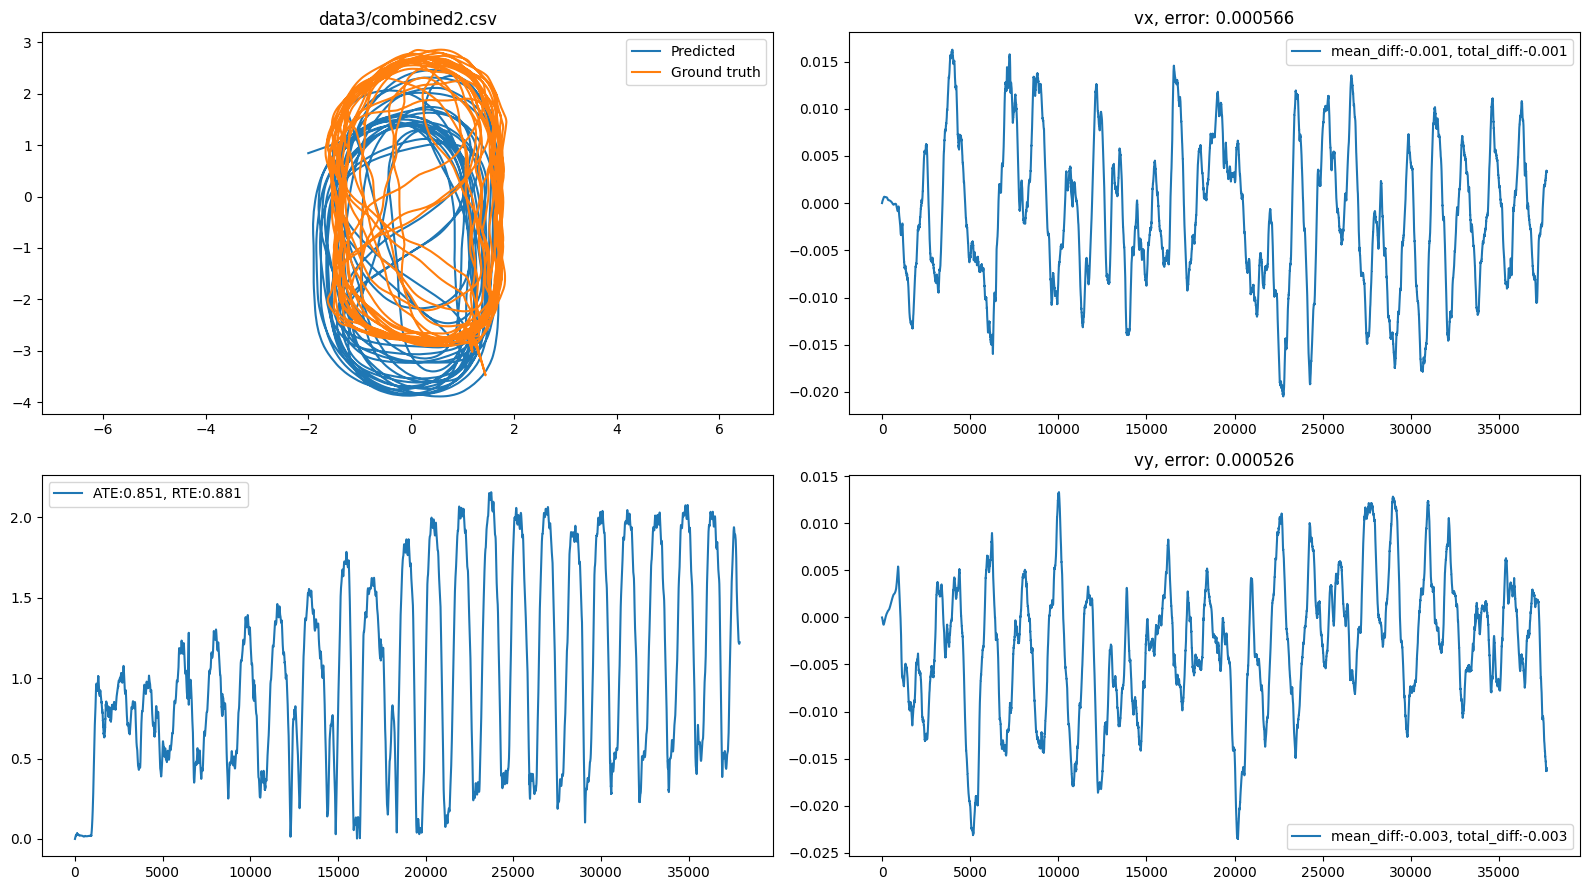

diff_x:  -0.001622244
diff_y:  -0.0036222723
length of pos_pred in func (bfore inter:  (60669, 2)
pos shape final: (60867, 2)
Sequence data3/combined3.csv, loss [0.000583 0.000484] / 0.0005333463291128999, ate 1.120557, rte 0.937789


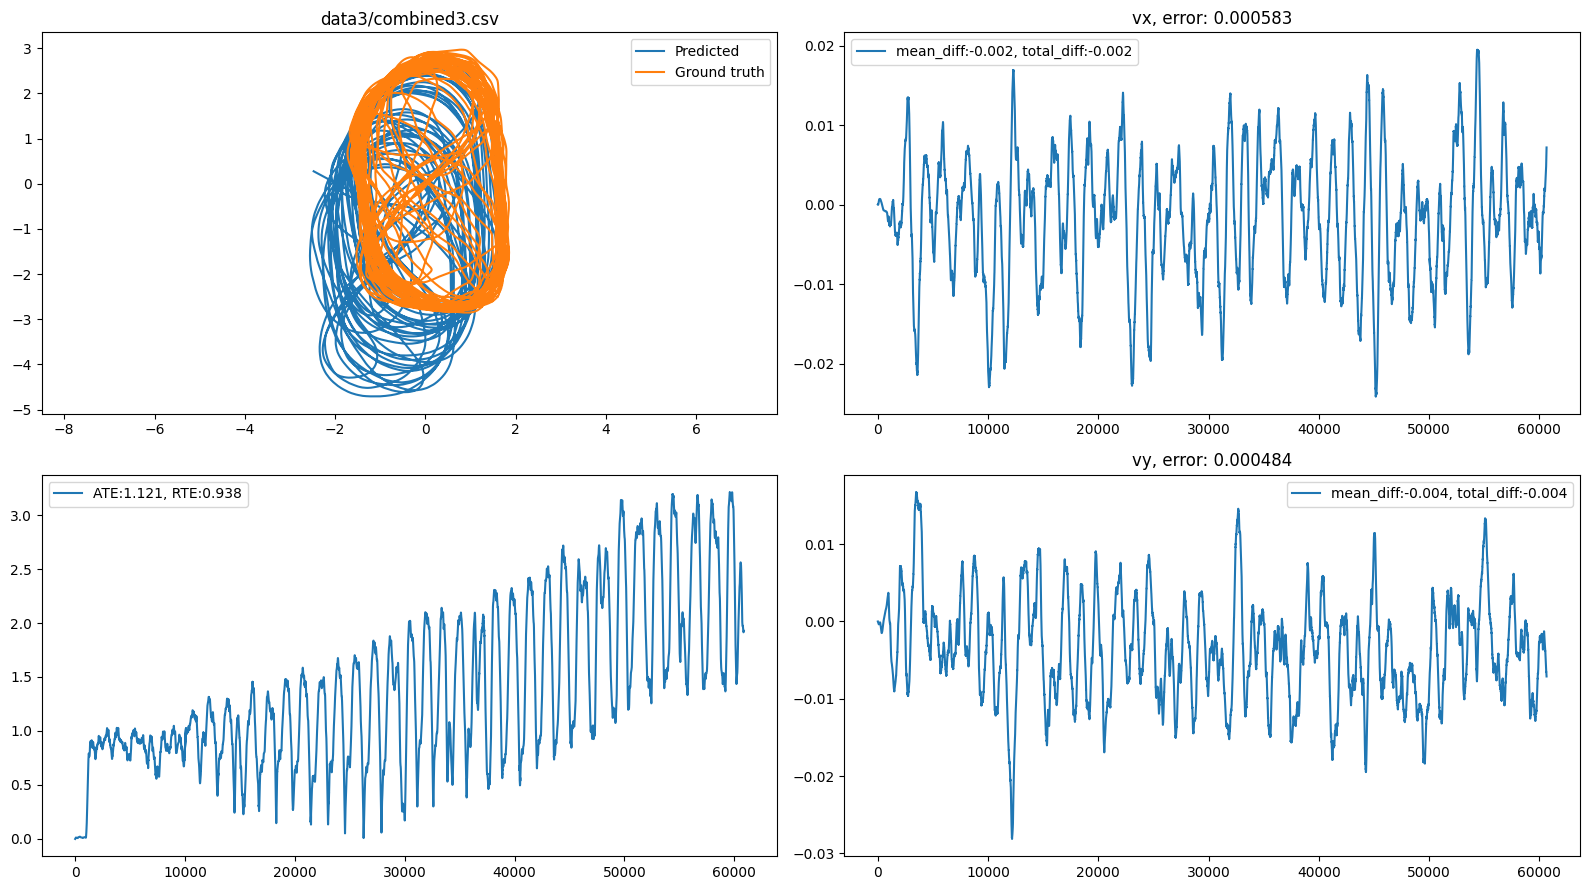

diff_x:  0.00048099956
diff_y:  -0.0014914871
length of pos_pred in func (bfore inter:  (31525, 2)
pos shape final: (31723, 2)
Sequence data4/combined1.csv, loss [0.000524 0.000448] / 0.00048580593375902286, ate 0.568847, rte 0.690924


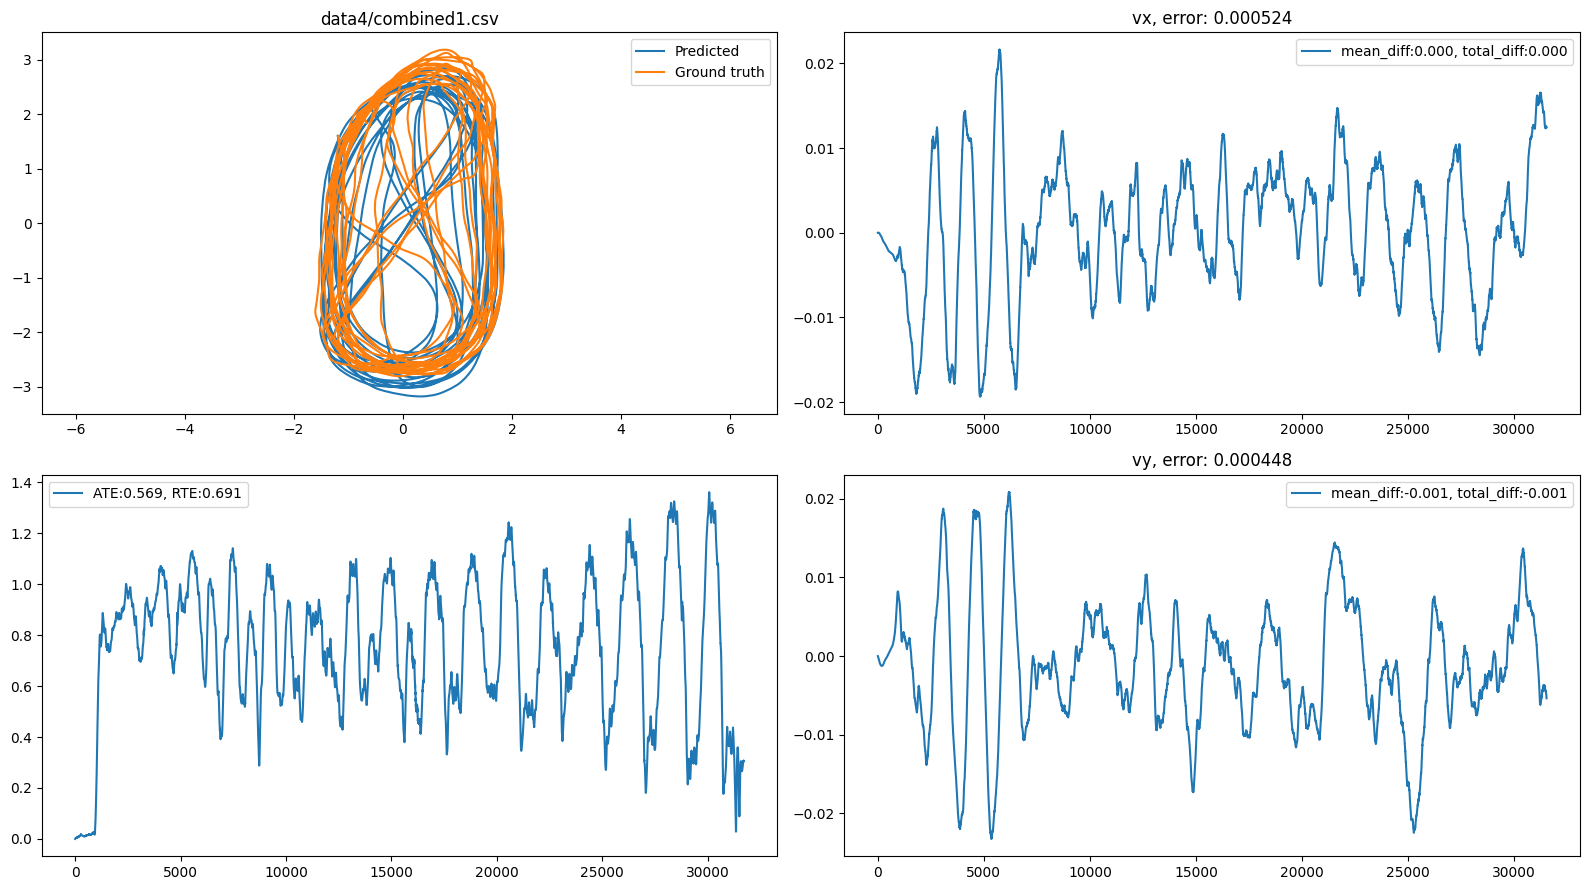

diff_x:  -0.00082796416
diff_y:  -0.0010100675
length of pos_pred in func (bfore inter:  (32029, 2)
pos shape final: (32227, 2)
Sequence data4/combined2.csv, loss [0.000534 0.000458] / 0.0004959057174417749, ate 0.568591, rte 0.831123


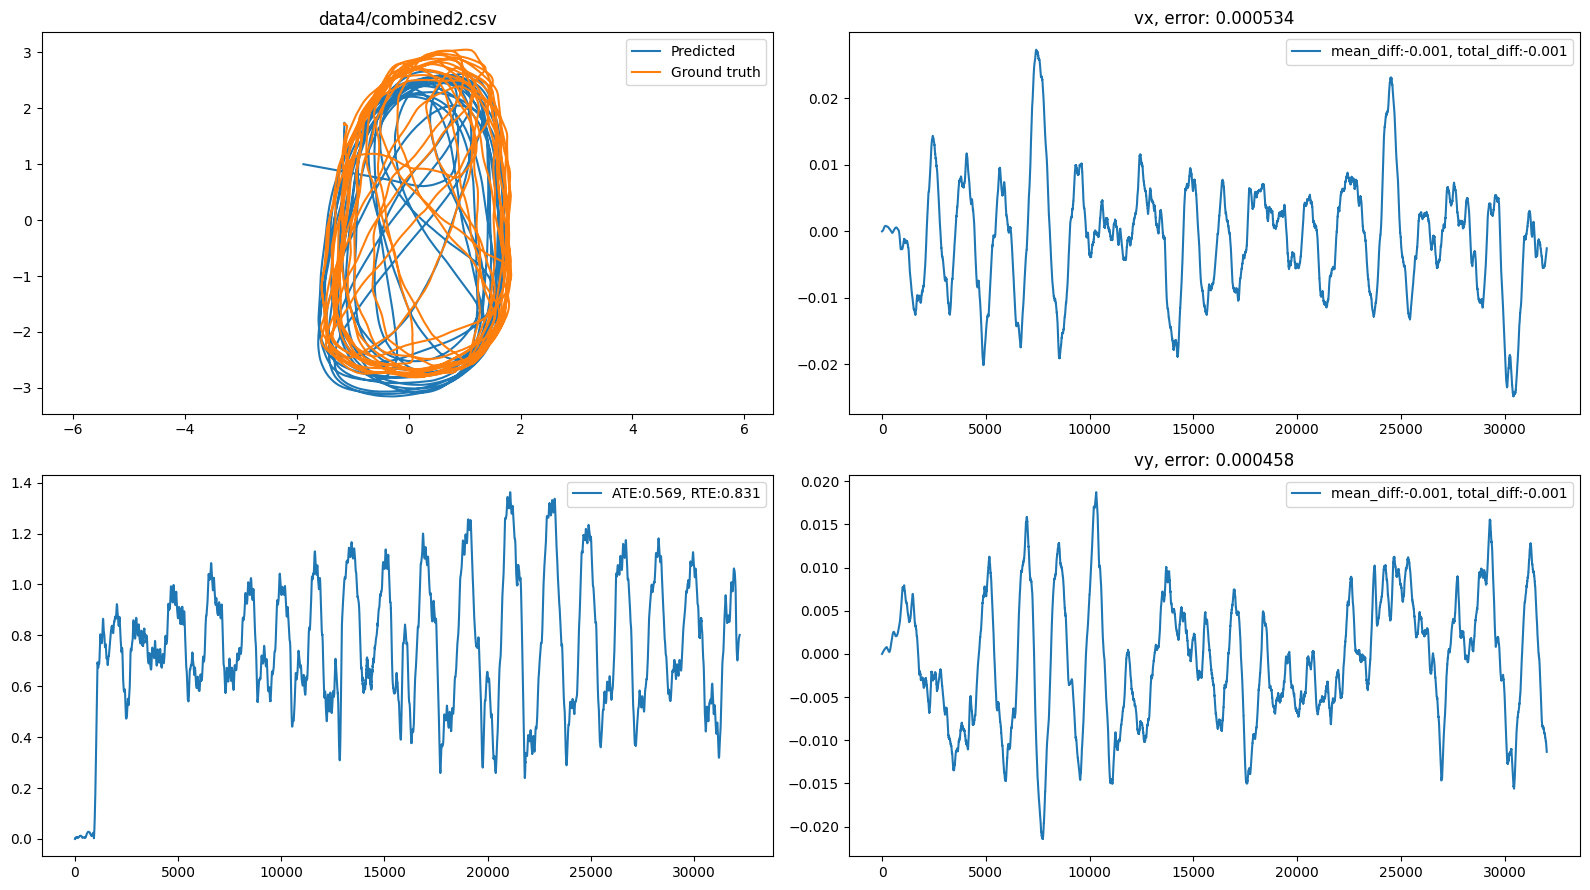

diff_x:  -2.7143975e-05
diff_y:  -0.002615363
length of pos_pred in func (bfore inter:  (60381, 2)
pos shape final: (60579, 2)
Sequence data4/combined3.csv, loss [0.000514 0.000442] / 0.0004782313357564855, ate 0.854943, rte 0.854561


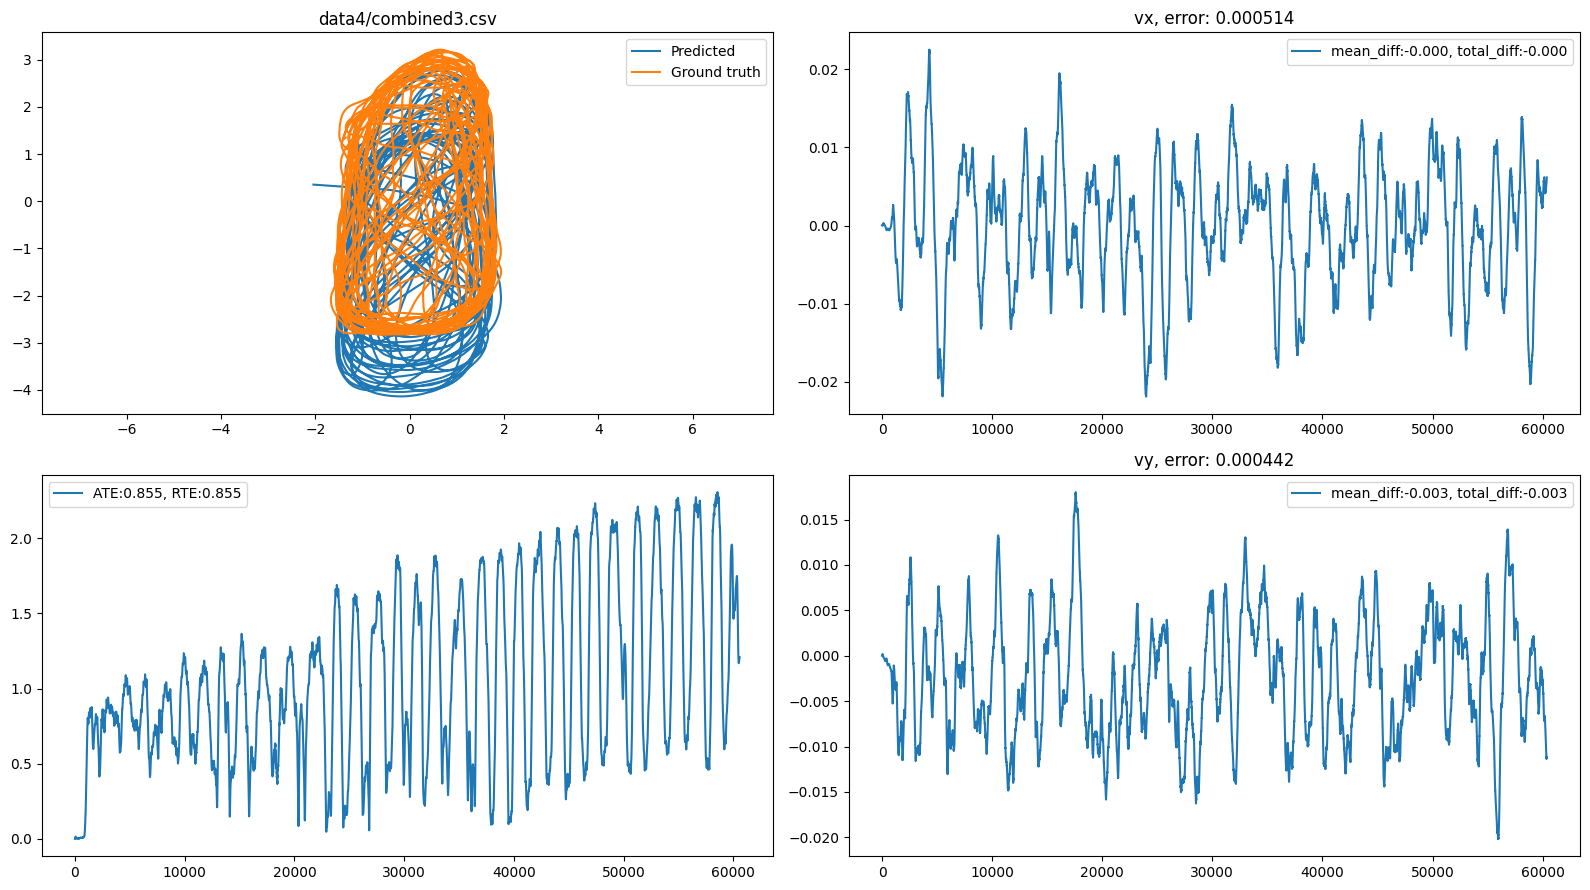

----------
Overall loss: [0.000560 0.000455]/0.0005075356017959213, avg ATE:0.6988802818294299, avg RTE:0.8519096928151045
=============================================================================outputs for pocket ==============================================================


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/resnet_diff_outputs/checkpoints/checkpoint_diff_loss.pt'

In [195]:
args.feature_sigma = 2
args.target_sigma = -1
args.saveAnim = False
args.step_size = 1
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley', 'large scale']
num_models = 1
for data in data_path_list:
    print(f'=============================================================================outputs for {data} ==============================================================')
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    args.test_list = osp.join(args.root_dir, 'Train.txt')
    args.out_dir = osp.join(args.root_dir, args.type + '_outputs')
    args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_diff_loss.pt')
    model_paths = [args.model_path]
    test_sequence(args, model_paths)

In [196]:
data_path_list = ['handbag', 'handheld', 'pocket', 'running', 'slow walking', 'trolley']
results_df = pd.DataFrame(columns = ['seq', 'ate', 'rte'])
for data in data_path_list:
    args.root_dir = osp.join('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset', data)
    Data = pd.read_csv(osp.join(args.root_dir, args.type+'_outputs/losses.csv'))[['seq', 'ate', 'rte']]
    combined = pd.concat([Data], axis = 1)
    results_df = pd.concat([results_df, combined], axis = 0)

fig, ax = plt.subplots(figsize=(10, 6))
results_df.plot(x='seq', y=['ate', 'rte'], kind='bar', ax = ax, title = 'ResNet prediction Error in domain', ylabel = 'Error(m)')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/pocket/resnet_diff_outputs/losses.csv'